# Building Models to Predict Loan Default

## Table of Contents
*  
    * [Part 1 : Data Loading, Transformation and Exploration](#part-1)
    * [Part 2 : Feature extraction and ML training](#part-2)
    * [Part 3 : Applicant Segmentation and Knowledge sharing with K-Mean](#part-3)
    * [Part 4 : Data Ethics, Privacy, and Security](#part-4)
 
Please add code/markdown cells as you need.

# Part 1: Data Loading, Transformation and Exploration <a class="anchor" name="part-1"></a>
## 1.1 Data Loading
In this section, you need to load the given datasets into PySpark DataFrames and use DataFrame functions to process the data, usage of Spark SQL is discouraged. You are allowed to use third-party libraries to format the output. For plotting, different visualisation packages can be used, please ensure that you have included instructions to install the additional packages and the installation will be successful in the provided docker container(in case your marker needs to clear the notebook and rerun it).

### 1.1.1 Data Loading <a class="anchor" name="1.1"></a>
Write the code to create a SparkSession. For creating the SparkSession, you need to use a SparkConf object to configure the Spark app with a proper application name, to ensure the maximum partition size does not exceed 20MB, and to run locally with 4 CPU cores on your machine. (2%)

In [1]:
from pyspark import SparkConf
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import pipeline
from pyspark.sql.types import *
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import StandardScaler
from pyspark.ml.stat import ChiSquareTest
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator,CrossValidatorModel
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [2]:
spark_conf = SparkConf()\
    .setAppName("A2 Building Models to Predict Loan Default")\
    .setMaster("local[4]")\
    .set("spark.sql.files.maxPartitionBytes", str(20 * 1024 *1024))
spark = SparkSession.builder.config(conf= spark_conf).getOrCreate()
sc = spark.sparkContext
sc.setLogLevel("ERROR")

1.1.2 Write code to define the schemas for previous_application and application_data, following the data types suggested in the metadata file. (3%)

In [3]:
prev_data_schema = StructType([
    StructField("id_app", IntegerType(), True),
    StructField("contract_type", IntegerType(), True),
    StructField("amt_annuity", FloatType(), True),
    StructField("amt_application", FloatType(), True),
    StructField("amt_credit", FloatType(), True),
    StructField("amt_down_payment", FloatType(), True),
    StructField("amt_goods_price", FloatType(), True),
    StructField("hour_appr_process_start", IntegerType(), True),
    StructField("rate_down_payment", FloatType(), True),
    StructField("rate_interest_primary", FloatType(), True),
    StructField("rate_interest_privileged", FloatType(), True),
    StructField("name_cash_loan_purpose", StringType(), True),
    StructField("name_contract_status", StringType(), True),
    StructField("days_decision", IntegerType(), True),
    StructField("name_payment_type", StringType(), True),
    StructField("code_reject_reason", StringType(), True),
    StructField("name_type_suite", StringType(), True),
    StructField("name_client_type", StringType(), True),
    StructField("name_goods_category", StringType(), True),
    StructField("name_portfolio", StringType(), True),
    StructField("name_product_type", StringType(), True),
    StructField("channel_type", StringType(), True),
    StructField("sellerplace_area", IntegerType(), True),
    StructField("name_seller_industry", StringType(), True),
    StructField("cnt_payment", FloatType(), True),
    StructField("name_yield_group", StringType(), True),
    StructField("product_combination", StringType(), True),
    StructField("days_first_drawing", FloatType(), True),
    StructField("days_first_due", FloatType(), True),
    StructField("days_last_due_1st_version", FloatType(), True),
    StructField("days_last_due", FloatType(), True),
    StructField("days_termination", FloatType(), True),
    StructField("nflag_insured_on_approval", FloatType(), True),
    StructField("id", LongType(), True)
])

In [4]:
app_data_schema = StructType([
    StructField("id_app", IntegerType(), True),
    StructField("target", IntegerType(), True),
    StructField("contract_type", IntegerType(), True),
    StructField("gender", StringType(), True),
    StructField("own_car", StringType(), True),
    StructField("own_property", StringType(), True),
    StructField("num_of_children", IntegerType(), True),
    StructField("income_total", FloatType(), True),
    StructField("amt_credit", FloatType(), True),
    StructField("amt_annuity", FloatType(), True),
    StructField("amt_goods_price", FloatType(), True),
    StructField("income_type", IntegerType(), True),
    StructField("education_type", IntegerType(), True),
    StructField("family_status", IntegerType(), True),
    StructField("housing_type", IntegerType(), True),
    StructField("region_population_relative", FloatType(), True),
    StructField("days_birth", IntegerType(), True),
    StructField("days_employed", IntegerType(), True),
    StructField("own_car_age", FloatType(), True),
    StructField("flag_mobile", IntegerType(), True),
    StructField("flag_emp_phone", IntegerType(), True),
    StructField("flag_work_phone", IntegerType(), True),
    StructField("flag_cont_mobile", IntegerType(), True),
    StructField("flag_phone", IntegerType(), True),
    StructField("flag_email", IntegerType(), True),
    StructField("occupation_type", IntegerType(), True),
    StructField("cnt_fam_members", FloatType(), True),
    StructField("weekday_app_process_start", StringType(), True),
    StructField("hour_app_process_start", IntegerType(), True),
    StructField("organization_type", IntegerType(), True),
    StructField("credit_score_1", FloatType(), False),
    StructField("credit_score_2", FloatType(), False),
    StructField("credit_score_3", FloatType(), False),
    StructField("days_last_phone_change", FloatType(), True),
    StructField("amt_credit_req_last_hour", FloatType(), True),
    StructField("amt_credit_req_last_day", FloatType(), True),
    StructField("amt_credit_req_last_week", FloatType(), True),
    StructField("amt_credit_req_last_month", FloatType(), True),
    StructField("amt_credit_req_last_quarter", FloatType(), True),
    StructField("amt_credit_req_last_year", FloatType(), True)])

1.1.3 Using your schemas from step 2, write code to load all CSV files into separate data frames(note: value_dict and loan_default are simple and don’t need schemas). Print the schemas of all data frames. (2%)

In [5]:
df_app_data = spark.read.csv("application_data.csv", header = True, schema= app_data_schema)
df_prev_app = spark.read.csv("previous_application.csv", header = True, schema= prev_data_schema)
df_value_dic = spark.read.csv("value_dict.csv", header = True, inferSchema= True)
df_loan_default = spark.read.csv("loan_default.csv", header = True, inferSchema= True)


In [6]:
df_value_dic.show(10)

+---+-----------------+--------------------+-----+
| id|         category|                 key|value|
+---+-----------------+--------------------+-----+
|  4|  name_type_suite|             Other_B|    2|
|  5|  name_type_suite|            Children|    3|
| 55|organization_type|Business Entity T...|    1|
| 56|organization_type|         Agriculture|    2|
| 57|organization_type|   Industry: type 13|    3|
| 58|organization_type|            Religion|    4|
| 59|organization_type|        Construction|    5|
| 60|organization_type|              Police|    6|
| 30|     housing_type|    Rented apartment|    1|
| 31|     housing_type|     Co-op apartment|    2|
+---+-----------------+--------------------+-----+
only showing top 10 rows



In [7]:
df_app_data.printSchema()

root
 |-- id_app: integer (nullable = true)
 |-- target: integer (nullable = true)
 |-- contract_type: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- own_car: string (nullable = true)
 |-- own_property: string (nullable = true)
 |-- num_of_children: integer (nullable = true)
 |-- income_total: float (nullable = true)
 |-- amt_credit: float (nullable = true)
 |-- amt_annuity: float (nullable = true)
 |-- amt_goods_price: float (nullable = true)
 |-- income_type: integer (nullable = true)
 |-- education_type: integer (nullable = true)
 |-- family_status: integer (nullable = true)
 |-- housing_type: integer (nullable = true)
 |-- region_population_relative: float (nullable = true)
 |-- days_birth: integer (nullable = true)
 |-- days_employed: integer (nullable = true)
 |-- own_car_age: float (nullable = true)
 |-- flag_mobile: integer (nullable = true)
 |-- flag_emp_phone: integer (nullable = true)
 |-- flag_work_phone: integer (nullable = true)
 |-- flag_cont_mobile

In [8]:
df_prev_app.printSchema()

root
 |-- id_app: integer (nullable = true)
 |-- contract_type: integer (nullable = true)
 |-- amt_annuity: float (nullable = true)
 |-- amt_application: float (nullable = true)
 |-- amt_credit: float (nullable = true)
 |-- amt_down_payment: float (nullable = true)
 |-- amt_goods_price: float (nullable = true)
 |-- hour_appr_process_start: integer (nullable = true)
 |-- rate_down_payment: float (nullable = true)
 |-- rate_interest_primary: float (nullable = true)
 |-- rate_interest_privileged: float (nullable = true)
 |-- name_cash_loan_purpose: string (nullable = true)
 |-- name_contract_status: string (nullable = true)
 |-- days_decision: integer (nullable = true)
 |-- name_payment_type: string (nullable = true)
 |-- code_reject_reason: string (nullable = true)
 |-- name_type_suite: string (nullable = true)
 |-- name_client_type: string (nullable = true)
 |-- name_goods_category: string (nullable = true)
 |-- name_portfolio: string (nullable = true)
 |-- name_product_type: string (nu

In [9]:
df_value_dic.printSchema()

root
 |-- id: integer (nullable = true)
 |-- category: string (nullable = true)
 |-- key: string (nullable = true)
 |-- value: integer (nullable = true)



In [10]:
df_loan_default.printSchema()

root
 |-- id_app: integer (nullable = true)
 |-- is_default: boolean (nullable = true)



### 1.2 Data Transformation and Create Features <a class="anchor" name="1.2"></a>
In this step, we’re going to perform data transformation and create some new features using existing information. (note: you are allowed to use your own code from assignment 1 for some transformation.)  
Perform the following tasks on the application_data data frame:

1.2.1 Create a new column called loan_to_income_ratio(loan to income ratio) defined as amt_credit/income_total.

In [11]:
df_app_data = df_app_data\
                .withColumn("loan_to_income_ratio", F.round(F.col("amt_credit") / F.col("income_total"),2))

1.2.2. Perform age bucketing and create a new string column called age_bucket and set the value below:  
age < 25: Y  
25 <= age <35: E  
35 <= age <45: M  
45 <= age < 55: L  
55 <= age < 65: N  
Age >= 65: R

In [12]:
def age_bucket (age):
    if age < 25:
        return "Y"
    elif age < 35:
        return "E" 
    elif age< 45:
        return "M"
    elif age < 55:
        return "L"
    elif age< 65:
        return "N"
    else :
        return "R"

In [13]:
age_bucket_udf = F.udf(age_bucket, StringType())

In [14]:
df_app_data = df_app_data.withColumn("age", F.floor(F.abs(F.col("days_birth"))/365.25)) \
    .withColumn("age_bucket", age_bucket_udf(F.col("age")))\
    .drop("age")

1.2.3 Create a new string column named credit_worthiness. It takes the average value of credit_score_1,2,3 (note: replace null value with 0.5, not 0). If the average >= 0.7, set credit_worthiness to “high”; 0.4 <= average <= 0.7 set to “medium”, < 0.4 set to “low”.

In [15]:
def credit_worthiness(score):
    if score >= 0.7:
        return "high"
    elif score >= 0.4:
        return "medium"
    else:
        return "low"
    

In [16]:
udf_credit_worthiness = F.udf(credit_worthiness, StringType())

I reused my code from A1

In [17]:
colum_fill_null = ['credit_score_1','credit_score_2','credit_score_3']
for columnName in colum_fill_null:
    df_app_data = df_app_data.withColumn(columnName, F.coalesce(F.col(columnName), F.lit(0.5)))

df_app_data = df_app_data.withColumn("credit_worthiness", 
                       (F.col("credit_score_1") + F.col("credit_score_2") + F.col("credit_score_3"))/3)\
                        .withColumn("credit_worthiness", udf_credit_worthiness(F.col("credit_worthiness")))

1.2.4 Create 4 columns: num_of_prev_app(number of previous applications), num_of_approved_app (number of approved applications), total_credit (sum of credit of all approved previous applications), total_credit_to_income_ratio (total credit/income).  (note: you need to join previous applications to fill in the values.)

In [18]:
df_prev_app = df_prev_app.groupBy("id_app") \
    .agg(
        F.count("*").alias("num_of_prev_app"),
        F.sum(F.when(F.col("name_contract_status") == "Approved", 1).otherwise(0)).alias("num_of_approved_app"),
        F.sum(F.when(F.col("name_contract_status") == "Approved", F.col("amt_credit")).otherwise(0)).alias("total_credit")
    )

df_app_joined = df_app_data.join(df_prev_app, "id_app", how = "left")
# Replace null value with 0, because we still need to do the prediction if a new customer applies for a loan.
need_fill_null = ["num_of_prev_app","num_of_approved_app","total_credit"]
for columnName in need_fill_null:
    df_app_joined = df_app_joined\
                            .withColumn(columnName, F.coalesce(F.col(columnName), F.lit(0)))
df_app_joined = df_app_joined\
                        .withColumn("total_credit_to_income_ratio", F.col("total_credit")/ F.col("income_total"))


------

1.2.5 Replace education_type, occupation_type, income_type and family_status with matching strings from value_dict (hint: consider reusing code from your A1).

In [19]:
# Broadcasting a dictionary created from a DataFrame (df_value_dic)
# This dictionary maps (category, value) pairs to a corresponding key.
# The purpose is to replace certain column values in another DataFrame (df_app_joined)
# with a corresponding 'key' based on the 'category' and 'value'.
value_to_key_map = spark.sparkContext.broadcast(
    {(row['category'], str(row['value'])): row['key'] for row in df_value_dic.collect()}
)

# Function to replace a column value with a key based on the given category.
# If the (category, value) pair is not found in the broadcasted dictionary,
# the original value is returned.
def replace_value_with_key(category, column_value):
    return value_to_key_map.value.get((category, str(column_value)), column_value)

udf_replace_value_with_key = F.udf(replace_value_with_key, StringType())
columns_to_replace = ["education_type", "occupation_type", "income_type", "family_status"]

for column in columns_to_replace:
    df_app_joined = df_app_joined\
                            .withColumn(column, udf_replace_value_with_key(F.lit(column), F.col(column)))

1.2.6 Join the loan_default data frame and add is_default to application data. We’ll use this column as the label.

In [20]:
df_app_joined = df_app_joined.join(df_loan_default, "id_app")

Print 10 records from the application_data data frame.

In [21]:
df_app_joined.show(10,vertical = True)

-RECORD 0--------------------------------------------
 id_app                       | 100003               
 target                       | 0                    
 contract_type                | 2                    
 gender                       | F                    
 own_car                      | N                    
 own_property                 | N                    
 num_of_children              | 0                    
 income_total                 | 270000.0             
 amt_credit                   | 1293502.5            
 amt_annuity                  | 35698.5              
 amt_goods_price              | 1129500.0            
 income_type                  | State servant        
 education_type               | Higher education     
 family_status                | Married              
 housing_type                 | 6                    
 region_population_relative   | 0.003541             
 days_birth                   | -16765               
 days_employed              

### 1.3 Exploring the Data <a class="anchor" name="1.3"></a>
1.3.1 With the transformed data frame from 1.2, write code to show the basic statistics (3%) (pandas is allowed for this task):  
a) For each numeric column, show count, mean, stddev, min, max, 25 percentile, 50 percentile, and 75 percentile;  
b) For each non-numeric column, display the top 5 based on counts in descending order;  
c) For each boolean column, display the value and count(i.e., two rows in total).

### a) For each numeric column:

In [22]:
numeric_cols = [c[0] for c in df_app_joined.dtypes if c[1] != "string" and c[1] != "boolean"]
print(numeric_cols)

['id_app', 'target', 'contract_type', 'num_of_children', 'income_total', 'amt_credit', 'amt_annuity', 'amt_goods_price', 'housing_type', 'region_population_relative', 'days_birth', 'days_employed', 'own_car_age', 'flag_mobile', 'flag_emp_phone', 'flag_work_phone', 'flag_cont_mobile', 'flag_phone', 'flag_email', 'cnt_fam_members', 'hour_app_process_start', 'organization_type', 'credit_score_1', 'credit_score_2', 'credit_score_3', 'days_last_phone_change', 'amt_credit_req_last_hour', 'amt_credit_req_last_day', 'amt_credit_req_last_week', 'amt_credit_req_last_month', 'amt_credit_req_last_quarter', 'amt_credit_req_last_year', 'loan_to_income_ratio', 'num_of_prev_app', 'num_of_approved_app', 'total_credit', 'total_credit_to_income_ratio']


In [23]:
cate_cols = [c[0] for c in df_app_joined.dtypes if c[1] == "string" ]
print(cate_cols)

['gender', 'own_car', 'own_property', 'income_type', 'education_type', 'family_status', 'occupation_type', 'weekday_app_process_start', 'age_bucket', 'credit_worthiness']


In [24]:
# show count, mean, stddev, min, max, 25 percentile, 50 percentile, and 75 percentile
df_app_joined.select(numeric_cols).summary().toPandas()

,summary,id_app,target,contract_type,num_of_children,income_total,amt_credit,amt_annuity,amt_goods_price,housing_type,...,amt_credit_req_last_day,amt_credit_req_last_week,amt_credit_req_last_month,amt_credit_req_last_quarter,amt_credit_req_last_year,loan_to_income_ratio,num_of_prev_app,num_of_approved_app,total_credit,total_credit_to_income_ratio
0,count,172591,172591,172591,172591,172591,172591,172583,172449,172591,...,149402,149402,149402,149402,149402,172591,172591,172591,172591,172591
1,mean,200080.7691594579,0.08146427102224334,1.9047690783412807,0.4192281173409969,168919.90492529122,599010.2970172256,27115.226940081004,538425.161160691,5.760595859575528,...,0.007168578733885758,0.03395536873669697,0.2662548024792171,0.26401922330357025,1.8909853951084992,3.9607339896055027,4.579659426041914,2.875781471803281,579670.4006848425,3.811772253742742
2,stddev,57754.034871099044,0.2735475774476058,0.29353448255375125,0.7244008877771795,299297.7295409112,402971.85118020145,14581.585410298538,370123.30767896475,0.8133292643667401,...,0.11387390231560299,0.20408647737756527,0.9150197434284009,0.6101023105982559,1.8648585646322067,2.697725739590265,4.163129191241205,2.178799874114663,757286.9217690701,4.971278336060549
3,min,100002,0,1,0,25650.0,45000.0,1980.0,45000.0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0
4,25%,149936,0,2,0,112500.0,270000.0,16506.0,238500.0,6,...,0.0,0.0,0.0,0.0,0.0,2.02,2,1,107712.0,0.7424
5,50%,200142,0,2,0,144000.0,512446.5,24894.0,450000.0,6,...,0.0,0.0,0.0,0.0,1.0,3.27,3,2,284040.0,2.0020384615384614
6,75%,250126,0,2,1,202500.0,808650.0,34596.0,679500.0,6,...,0.0,0.0,0.0,0.0,3.0,5.17,6,4,753781.5,5.0078
7,max,299999,1,2,19,1.17E8,4050000.0,258025.5,4050000.0,6,...,9.0,8.0,24.0,8.0,25.0,84.74,73,24,1.03703805E7,104.13057142857143


## b) For each non-numeric column

In [25]:
# For each non-numeric column, display the top 5 most frequent values
for column in cate_cols:
    print(f"Top 5 most frequent values in {column}:")
    df_app_joined.select(column) \
                 .groupBy(column) \
                 .agg(F.count("*").alias("count")) \
                 .orderBy(col("count").desc()) \
                 .show(5)
    print("\n")

Top 5 most frequent values in gender:
+------+------+
|gender| count|
+------+------+
|     F|113467|
|     M| 59121|
|   XNA|     3|
+------+------+



Top 5 most frequent values in own_car:
+-------+------+
|own_car| count|
+-------+------+
|      N|113887|
|      Y| 58704|
+-------+------+



Top 5 most frequent values in own_property:
+------------+------+
|own_property| count|
+------------+------+
|           Y|119580|
|           N| 53011|
+------------+------+



Top 5 most frequent values in income_type:
+--------------------+-----+
|         income_type|count|
+--------------------+-----+
|             Working|89283|
|Commercial associate|40237|
|           Pensioner|30983|
|       State servant|12057|
|          Unemployed|   13|
+--------------------+-----+
only showing top 5 rows



Top 5 most frequent values in education_type:
+--------------------+------+
|      education_type| count|
+--------------------+------+
|Secondary / secon...|122629|
|    Higher education| 4204

## c):for boolean column

In [26]:
df_app_joined.select("is_default").groupBy("is_default").count().show()

+----------+------+
|is_default| count|
+----------+------+
|      true|  5162|
|     false|167429|
+----------+------+



1.3.2 Explore the data frame and write code to present two plots worthy of presentation to MoLoCo, describe your plots and discuss the findings from the plots. (8%)  
- One plot must be related to the default. (e.g. what attribute/attributes are correlated to default, what kind of application/applicant has a higher probability of default, etc.)   
- Feel free to choose any for the other plot.  
- Hint: you can use the basic plots (e.g., histograms, line charts, scatter plots) for the relationship between a column and the label; or more advanced plots like correlation plots. If the data is too large for the plotting, consider using sampling before plotting.  
- 150 words max for each plot’s description and discussion  
- Feel free to use any plotting libraries: matplotlib, seabon, plotly, etc.  


In [27]:
df_app_joined.groupBy("flag_mobile").agg(F.count("*")).show()

+-----------+--------+
|flag_mobile|count(1)|
+-----------+--------+
|          1|  172590|
|          0|       1|
+-----------+--------+



I droped `flag_mobile` because I realized it only had one record that was different. id_app" only indicates the user ID and is not important.`target` not in use here.

In [28]:
df_app_corr = df_app_joined.withColumn("is_default", F.when(F.col("is_default") == True, 1).otherwise(0))\
                    .withColumnRenamed("is_default", "label")\
                    .select(numeric_cols + ["label"])\
                    .drop("target","id_app",'flag_mobile')
corr_matrix = df_app_corr.sample(fraction= 0.1).toPandas().corr()


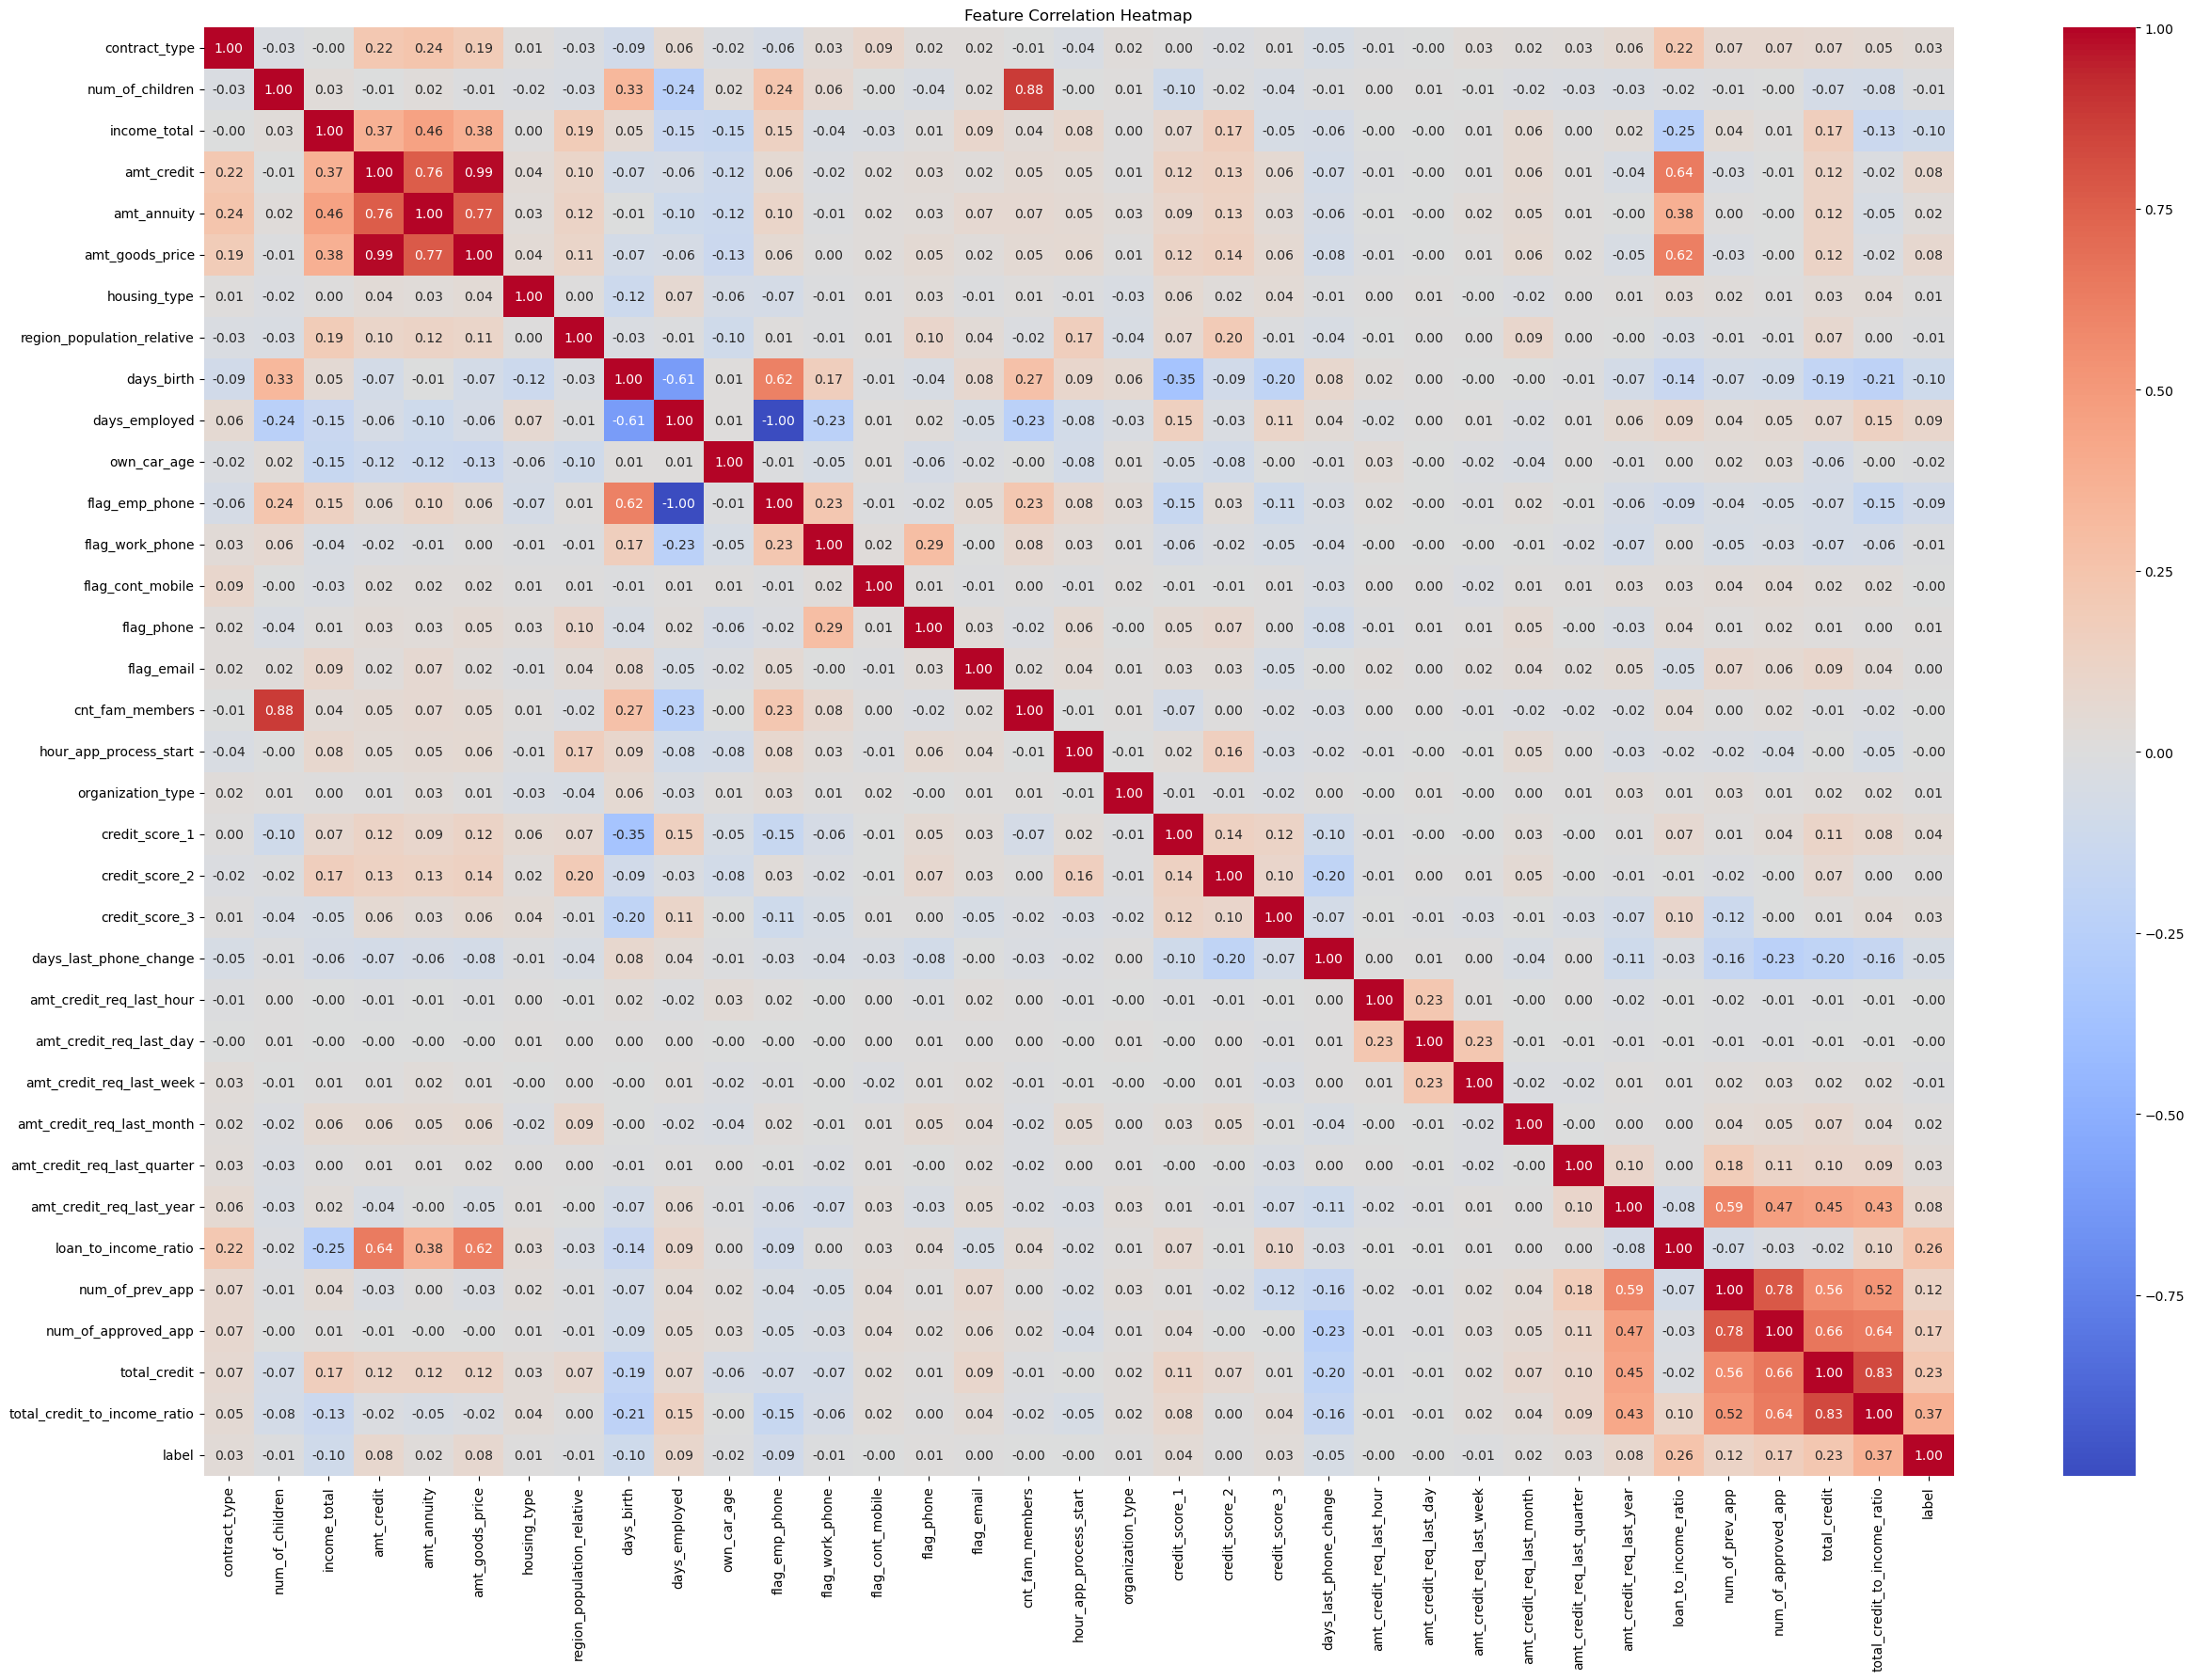

In [29]:
plt.figure(figsize=(30, 20))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

Some features exhibit a strong correlation with the label and are shown in dark colors. For example, features like loan_to_income_ratio, total_credit_to_income_ratio, num_of_approved_app, and total_credit have high correlation coefficients, indicating a close relationship with the label. This suggests that these features may play a significant role in predicting the label, such as credit risk or loan approval.

On the other hand, certain features are almost colorless, such as num_of_children and housing_type. Their correlation with the label is low or close to zero. This may imply that these features are not very important for predicting the label.

-----

I would also like to further discover the relationship between default rates and different age groups

In [30]:
pd_plot2 = df_app_joined.groupBy("age_bucket").agg(
    F.count("*").alias("total_number"),
    F.sum(F.when(F.col("is_default") == True, 1).otherwise(0)).alias("num_default")
    )
pd_plot2 = pd_plot2.withColumn("default_ratio", F.col("num_default") / F.col("total_number"))
pd_plot2_df = pd_plot2.toPandas()


In [31]:
pd_plot2_df.head()

,age_bucket,total_number,num_default,default_ratio
0,E,40820,488,0.011955
1,Y,6883,16,0.002325
2,L,39292,1264,0.032169
3,M,47263,1133,0.023972
4,N,33902,2061,0.060793


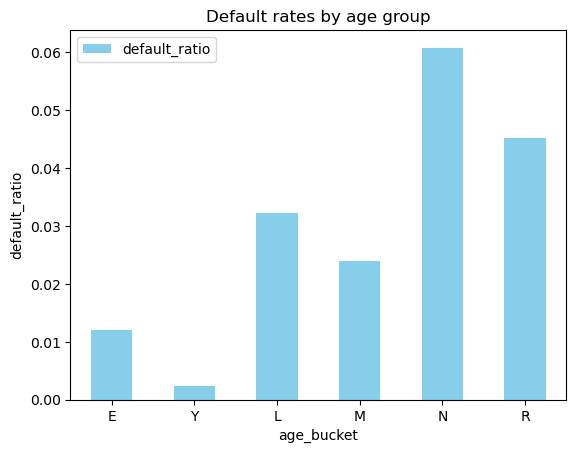

In [32]:
pd_plot2_df.plot(kind='bar', x='age_bucket', y='default_ratio', color='skyblue')
plt.title('Default rates by age group')
plt.xlabel('age_bucket')
plt.ylabel('default_ratio')
plt.xticks(rotation=0)  # To keep the labels horizontal
plt.show()

This chart demonstrates that there is a certain relationship between age and default rates, albeit influenced by other factors. Younger individuals and those aged between 25 to 35 years typically exhibit lower default risk, with individuals under 25 (represented as Y) showing the lowest default rate at just 0.23%. This could be attributed to their relatively fewer financial commitments and a shorter credit history, resulting in lower default likelihood.

Conversely, individuals aged between 45 to 55 years tend to have higher default rates, possibly due to increased financial responsibilities, including mortgages and education expenses. Additionally, individuals aged 55 to 65 (represented as N) display a higher default rate of 6.08%, which may reflect some retired individuals who experience reduced financial pressure but still carry some default risk.

-----

## Part 2. Feature extraction and ML training <a class="anchor" name="part-2"></a>
In this section, you are only allowed to use PySpark DataFrame functions and ML packages for data preparation, model building, and evaluation. Other ML packages, such as scikit-learn, would receive zero marks. Excessive usage of Spark SQL is discouraged.
### 2.1 Discuss the feature selection and prepare the feature columns

2.1.1 Based on the data exploration from 1.2 and considering the use case, discuss the importance of those features. (For example, which features may be useless and should be removed, which feature has a great impact on the label column, which should be transformed) Which features you are planning to use? Discuss the reasons for selecting them and how you create/transform them
- 300 words max for the discussion
- Feel free to add/remove features based on your exploration

In [33]:
df_app_joined = df_app_joined.withColumn("is_default", F.when(F.col("is_default") == True, 1).otherwise(0))\
                    .withColumnRenamed("is_default", "label")

In [35]:
null_check = df_app_joined.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_app_joined.columns])
# fill null value
null_counts_dict = null_check.collect()[0].asDict()
null_columns = [c for c, count in null_counts_dict.items() if count > 0]

for columnName in null_columns:
    df_app_joined = df_app_joined.withColumn(columnName, F.coalesce(F.col(columnName), F.lit(0)))

In [36]:
numeric_cols = [c[0] for c in df_app_joined.dtypes if c[1] != "string" and c[0]!= "label"]
print(numeric_cols)

['id_app', 'target', 'contract_type', 'num_of_children', 'income_total', 'amt_credit', 'amt_annuity', 'amt_goods_price', 'housing_type', 'region_population_relative', 'days_birth', 'days_employed', 'own_car_age', 'flag_mobile', 'flag_emp_phone', 'flag_work_phone', 'flag_cont_mobile', 'flag_phone', 'flag_email', 'cnt_fam_members', 'hour_app_process_start', 'organization_type', 'credit_score_1', 'credit_score_2', 'credit_score_3', 'days_last_phone_change', 'amt_credit_req_last_hour', 'amt_credit_req_last_day', 'amt_credit_req_last_week', 'amt_credit_req_last_month', 'amt_credit_req_last_quarter', 'amt_credit_req_last_year', 'loan_to_income_ratio', 'num_of_prev_app', 'num_of_approved_app', 'total_credit', 'total_credit_to_income_ratio']


In [37]:
correlation_dict = {}

# Calculate the correlation between each numerical feature and the label
for feature in numeric_cols:
    correlation = df_app_joined.stat.corr(feature, "label")
    correlation_dict[feature] = correlation

# Output correlation coefficients
for k, v in sorted(correlation_dict.items(), key=lambda item: item[1], reverse=True):
    print(f"{k}: {v}")

# Select features with high absolute correlation before importing the abs function from PySpark
selected_features = [feature for feature, corr in correlation_dict.items() if np.abs(corr) > 0.1]  # a threshold of 0.1


total_credit_to_income_ratio: 0.38228183614999023
loan_to_income_ratio: 0.2602064951083459
total_credit: 0.2505849302903361
num_of_approved_app: 0.17004968104585078
num_of_prev_app: 0.12556502074470482
amt_credit: 0.09305910283869333
amt_goods_price: 0.09163232934758837
days_employed: 0.09011558652894608
amt_credit_req_last_year: 0.08279042386276833
credit_score_1: 0.040857036904405626
contract_type: 0.03842454729353349
amt_annuity: 0.0313936980029076
credit_score_3: 0.026521221876799537
flag_phone: 0.015220708841308071
amt_credit_req_last_quarter: 0.014633114958436907
housing_type: 0.0065997730382451976
flag_cont_mobile: 0.004748463571639492
amt_credit_req_last_month: 0.0027118058734951975
id_app: 0.0009882469295017426
amt_credit_req_last_hour: 0.0007822565789641565
flag_mobile: 0.0004226548377623021
organization_type: -0.000559087133060676
amt_credit_req_last_day: -0.0022572052526784177
cnt_fam_members: -0.002696979115830898
credit_score_2: -0.002965065184732752
flag_email: -0.003707

In [38]:
cate_cols = [c[0] for c in df_app_joined.dtypes if c[1] == "string"]

# Specify input and output columns for StringIndexer
chi_inputCols = cate_cols
chi_outputCols = [f'{x}_index' for x in cate_cols]

# Create a StringIndexer to index categorical features
chi_indexer = StringIndexer(inputCols=chi_inputCols, outputCols=chi_outputCols)
df_indexed = chi_indexer.fit(df_app_joined).transform(df_app_joined)

# Use VectorAssembler to construct feature vectors
chi_assembler = VectorAssembler(inputCols=chi_outputCols, outputCol="features")
df_assembled = chi_assembler.transform(df_indexed)

# Apply the Chi-Square test
r = ChiSquareTest.test(df_assembled, "features", "label").head()

print("pValues: " + str(r.pValues))
print("degreesOfFreedom: " + str(r.degreesOfFreedom))
print("statistics: " + str(r.statistics))

# Set the significance level
significance_level = 0.05

# Extract p-values
p_values = r.pValues

# Determine the retained categorical features
selected_cat_features = [chi_inputCols[i] for i in range(len(p_values)) if p_values[i] < significance_level]

print("Selected categorical features:", selected_cat_features)


pValues: [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.28159431042186467,0.0,0.0]
degreesOfFreedom: [2, 1, 1, 7, 4, 5, 18, 6, 5, 2]
statistics: [972.6296433023457,980.5098698020106,559.9893929120524,1476.3930100121906,258.0592914742541,1023.1248622875457,1034.5963354386222,7.44560583919485,1848.2511657575062,100.6302153215297]
Selected categorical features: ['gender', 'own_car', 'own_property', 'income_type', 'education_type', 'family_status', 'occupation_type', 'age_bucket', 'credit_worthiness']


Based on the heatmap I previously observed and the correlation coefficients I calculated between various numerical features and the label (label), I found that total_credit_to_income_ratio, loan_to_income_ratio, and total_credit show strong positive correlations. This implies that they increase as the target variable increases. These may be key indicators, especially in credit risk assessment.

num_of_approved_app and num_of_prev_app also show some degree of positive correlation. These may represent the client's credit history, which could have a certain impact on credit risk assessment.

days_birth is negatively correlated with the target variable. In credit assessment, age might be an important factor as it could be related to the applicant's stability and length of credit history.

In feature selection, the p-values and statistics from the Chi-Square test are crucial considerations. In the results, all features except one (which has a p-value of 0.2816, higher than the significance level of 0.05) have p-values of 0.0. This indicates a significant statistical association between these features and the label (i.e., default risk). These features include gender, car ownership, property ownership, income type, education type, family status, occupation type, age group, and creditworthiness. 


The high statistical association suggests that these features could significantly impact predicting a customer's likelihood of default. For instance, income type and education level might affect a person's debt repayment capability, while family status and occupation type might reflect their financial stability. These categorical features are instrumental in building a more accurate credit risk assessment model.

2.1.2 Write code to create/transform the columns based on your discussion above. 


In [39]:
choosed_features = selected_features + selected_cat_features +["label"]
print(choosed_features)

['days_birth', 'loan_to_income_ratio', 'num_of_prev_app', 'num_of_approved_app', 'total_credit', 'total_credit_to_income_ratio', 'gender', 'own_car', 'own_property', 'income_type', 'education_type', 'family_status', 'occupation_type', 'age_bucket', 'credit_worthiness', 'label']


In [40]:
df_app_joined = df_app_joined.select(choosed_features)


### 2.2 Preparing Spark ML Transformers/Estimators for features, labels, and models  <a class="anchor" name="2.2"></a>

2.2.1 Write code to create Transformers/Estimators for transforming/assembling the columns you selected above in 2.1, and create ML model Estimators for Random Forest (RF) and Gradient-boosted tree (GBT) model.  
**Please DO NOT fit/transform the data yet**

In [41]:
inputCols = selected_cat_features
outputCols = [f"{x}_index" for x in selected_cat_features]
indexer = StringIndexer(inputCols = inputCols, outputCols= outputCols, handleInvalid= "keep")
outputOhe = [f"{x}_vec" for x in selected_cat_features]
encoder = OneHotEncoder(inputCols= outputCols, outputCols= outputOhe)
assemblerInputs = outputOhe + selected_features
assembler = VectorAssembler(inputCols = assemblerInputs, outputCol="features")
rf_classifier = RandomForestClassifier(featuresCol= "features", labelCol="label")
gbt_classifier = GBTClassifier(featuresCol= 'features', labelCol="label")


2.2.2 Write code to include the above Transformers/Estimators into two pipelines(RF and GBT).
**Please DO NOT fit/transform the data yet**

In [42]:
rf_pipeline = Pipeline(stages = [indexer, encoder, assembler, rf_classifier])
gbt_pipeline = Pipeline(stages = [indexer, encoder, assembler, gbt_classifier])

### 2.3 Prepare, Train and Evaluate models  
2.3.1 Write code to split the data for training and testing purposes. (Note: if the dataset is too large for your machine to train, sampling/sub-sampling is allowed.)

In [43]:
df_app_joined.groupBy("label").count().show()

+-----+------+
|label| count|
+-----+------+
|    1|  5162|
|    0|167429|
+-----+------+



Models trained on extremely imbalanced datasets tend to be biased towards the majority class, as this allows for high accuracy by simply predicting the most common class. This leads to poor predictive performance for the minority class.









I used the under-sampling method. I reduced the number of samples in the majority class to approximately match the number of samples in the minority class.

In [44]:
# First, create two separate DataFrames for each class
df_class_1 = df_app_joined.filter(F.col("label") == 1)  
df_class_0 = df_app_joined.filter(F.col("label") == 0)  

# Calculate the ratio of the number of records in both classes
class_1_count = df_class_1.count()  
class_0_count = df_class_0.count()  
fraction = class_1_count / class_0_count  

# Sample the class with more records to balance the dataset
df_class_0_sampled = df_class_0.sample(fraction=fraction)  
# Combine the sampled data with the minority class data
df_balanced = df_class_1.union(df_class_0_sampled) 

In [45]:
train, test = df_balanced.randomSplit([0.7, 0.3], seed = 3001)

2.3.2 Write code to use the corresponding ML Pipelines to train the models on the training data. And then use the trained models to predict the testing data from 2.3.

In [46]:
rf_model = rf_pipeline.fit(train)
rf_predictions = rf_model.transform(test)
gbt_model = gbt_pipeline.fit(train)
gbt_predictions = gbt_model.transform(test)

2.4.2 For both models(RF and GBT) and testing data, write code to display the count of TP/TN/FP/FN. Compute the AUC, accuracy, recall, and precision for the above-threshold/below-threshold label from each model testing result using pyspark MLlib/ML APIs.
1. Draw an ROC plot.
2. Discuss which one is the better model and use metrics to support your claim (no word limit, please keep it concise)

In [47]:
print("RF:")
rf_predictions.groupBy('label', 'prediction').count().show()

print("GBT:")
gbt_predictions.groupBy('label', 'prediction').count().show()

RF:
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|   99|
|    1|       1.0| 1434|
|    0|       0.0| 1288|
|    0|       1.0|  300|
+-----+----------+-----+

GBT:
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|   91|
|    1|       1.0| 1442|
|    0|       0.0| 1366|
|    0|       1.0|  222|
+-----+----------+-----+



In [48]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
auc_rf = evaluator.evaluate(rf_predictions)
print("AUC of RF is:",auc_rf)

auc_gbt = evaluator.evaluate(gbt_predictions)
print("AUC of GBT is:",auc_gbt)

AUC of RF is: 0.9375417966779549
AUC of GBT is: 0.957359172922817


I reffer the code from [Week6_Classification Algorithms sample solution](http://127.0.0.1:5202/notebooks/Week6_Classification%20Algorithms%20sample%20solution.ipynb) to caculate the evaluate score and draw the ROC plot

In [49]:
def compute_metrics(predictions):
    # Calculate the elements of the confusion matrix
    TN = predictions.filter('prediction = 0 AND label = prediction').count()
    TP = predictions.filter('prediction = 1 AND label = prediction').count()
    FN = predictions.filter('prediction = 0 AND label <> prediction').count()
    FP = predictions.filter('prediction = 1 AND label <> prediction').count()
    
    # calculate metrics by the confusion matrix
    accuracy = (TN + TP) / (TN + TP + FN + FP)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall
    }

rf_metrics = compute_metrics(rf_predictions)
gbt_metrics = compute_metrics(gbt_predictions)

# Create a pandas DataFrame
metrics_df = pd.DataFrame({'RF': rf_metrics, 'GBT': gbt_metrics})

# Transpose the DataFrame to get the desired format
metrics_df = metrics_df.T

print(metrics_df)

     accuracy  precision    recall
RF   0.872156   0.826990  0.935421
GBT  0.899712   0.866587  0.940639


Area Under ROC of RF: 0.9375393320089846


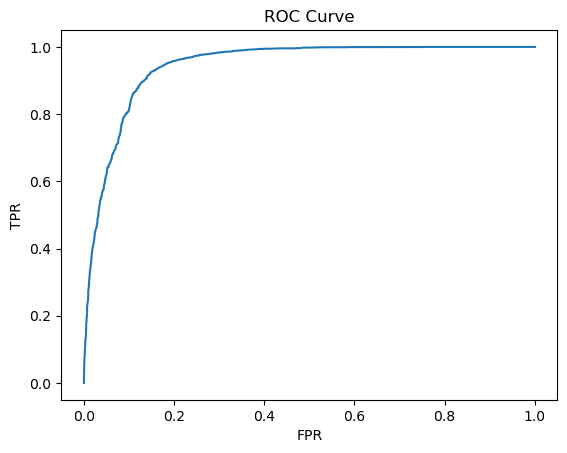

In [50]:
print("Area Under ROC of RF: " + str(evaluator.evaluate(rf_predictions, {evaluator.metricName: "areaUnderROC"})))

# Plot ROC curve
trainingSummary = rf_model.stages[-1].summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.title('ROC Curve')
plt.show()

/opt/conda/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Area Under ROC of GBT: 0.9573591729228169


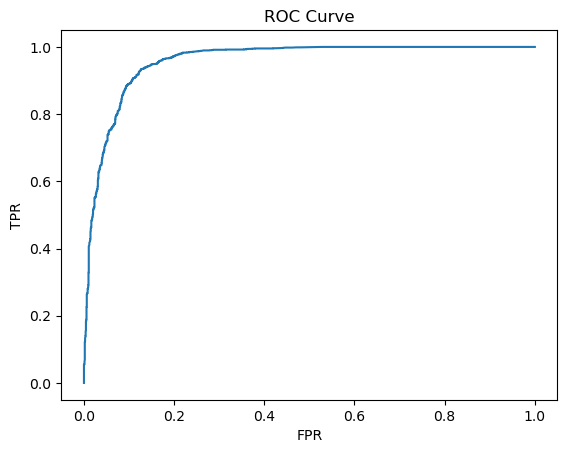

In [51]:
# Referenced from https://stackoverflow.com/questions/52847408/pyspark-extract-roc-curve
# Scala version implements .roc() and .pr()
# Python: https://spark.apache.org/docs/latest/api/python/_modules/pyspark/mllib/common.html
# Scala: https://spark.apache.org/docs/latest/api/java/org/apache/spark/mllib/evaluation/BinaryClassificationMetrics.html
class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        # Note this collect could be inefficient for large datasets 
        # considering there may be one probability per datapoint (at most)
        # The Scala version takes a numBins parameter, 
        # but it doesn't seem possible to pass this from Python to Java
        for row in rdd.collect():
            # Results are returned as type scala.Tuple2, 
            # which doesn't appear to have a py4j mapping
            points += [(float(row._1()), float(row._2()))]
            
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

preds = gbt_predictions.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
points = CurveMetrics(preds).get_curve('roc')

print("Area Under ROC of GBT: " + str(evaluator.evaluate(gbt_predictions, {evaluator.metricName: "areaUnderROC"})))
plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title("ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.plot(x_val, y_val)

2.4.3 Save the better model, we will need this for Part B of assignment 2.
(note: You may need to go through a few training loops, adjust features, use more data and other techniques to create a better-performing model.)

In [52]:
# Create ParamGrid for Cross Validation
rfparamGrid = (ParamGridBuilder()
             .addGrid(rf_classifier.maxDepth, [2, 5, 10, 20, 30])
             .addGrid(rf_classifier.maxBins, [10, 20, 40, 80, 100])
             .build())
# Define an evaluator to be used for evaluating the model 
rfevaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
# Create 3-fold CrossValidator
rfcv = CrossValidator(estimator = rf_pipeline,
                      estimatorParamMaps = rfparamGrid,
                      evaluator = rfevaluator,
                      numFolds = 3)
# Run cross validations
rf_cv_model = rfcv.fit(train)



In [53]:
best_rf_model = rf_cv_model.bestModel
print("Best param for model:", best_rf_model.stages[-1]._java_obj.paramMap())

Best param for model: {
	RandomForestClassifier_4eca4a120b9b-featuresCol: features,
	RandomForestClassifier_4eca4a120b9b-labelCol: label,
	RandomForestClassifier_4eca4a120b9b-maxBins: 100,
	RandomForestClassifier_4eca4a120b9b-maxDepth: 30
}


In [54]:
# By comparing with the initial model, the performance is significantly improved
best_model_predictions = best_rf_model.transform(test)
compute_metrics(best_model_predictions)

{'accuracy': 0.887856456264018,
 'precision': 0.8497930218805441,
 'recall': 0.9373776908023483}

In [55]:
auc_best_model = evaluator.evaluate(best_model_predictions)
print(auc_best_model)

0.9475440395267175


## GBT

In [56]:
gbt_paramGrid = (ParamGridBuilder()
                .addGrid(gbt_classifier.maxDepth, [2, 5, 10])
                .addGrid(gbt_classifier.maxBins, [20, 40, 60])
                .addGrid(gbt_classifier.maxIter, [10, 20, 30])
                .build())

gbt_evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")

gbt_cv = CrossValidator(estimator = gbt_pipeline,
                        estimatorParamMaps = gbt_paramGrid,
                        evaluator = gbt_evaluator,
                        numFolds = 3)

gbt_cv_model = gbt_cv.fit(train)

In [57]:
best_gbt_model = gbt_cv_model.bestModel
print("Best param for model:", best_gbt_model.stages[-1]._java_obj.paramMap())

Best param for model: {
	GBTClassifier_1cdb0a8b9168-featuresCol: features,
	GBTClassifier_1cdb0a8b9168-labelCol: label,
	GBTClassifier_1cdb0a8b9168-maxBins: 40,
	GBTClassifier_1cdb0a8b9168-maxDepth: 5,
	GBTClassifier_1cdb0a8b9168-maxIter: 30
}


In [58]:
best_gbt_model_predictions = best_gbt_model.transform(test)
compute_metrics(best_gbt_model_predictions)

{'accuracy': 0.9006728612624159,
 'precision': 0.8685955394816154,
 'recall': 0.9399869536855838}

In [59]:
auc_best_gbt_model = evaluator.evaluate(best_gbt_model_predictions)
print(auc_best_gbt_model)

0.9559929247569424


In [60]:
# I deciside save the gbt model due to it has better performance
best_gbt_model.save("best_classification_model")

Py4JJavaError: An error occurred while calling o92733.save.
: java.io.IOException: Path best_classification_model already exists. To overwrite it, please use write.overwrite().save(path) for Scala and use write().overwrite().save(path) for Java and Python.
	at org.apache.spark.ml.util.FileSystemOverwrite.handleOverwrite(ReadWrite.scala:683)
	at org.apache.spark.ml.util.MLWriter.save(ReadWrite.scala:167)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.super$save(Pipeline.scala:344)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.$anonfun$save$4(Pipeline.scala:344)
	at org.apache.spark.ml.MLEvents.withSaveInstanceEvent(events.scala:174)
	at org.apache.spark.ml.MLEvents.withSaveInstanceEvent$(events.scala:169)
	at org.apache.spark.ml.util.Instrumentation.withSaveInstanceEvent(Instrumentation.scala:42)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.$anonfun$save$3(Pipeline.scala:344)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.$anonfun$save$3$adapted(Pipeline.scala:344)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.save(Pipeline.scala:344)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:568)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:833)


### Part 3. Applicant Segmentation and Knowledge sharing with K-Mean <a class="anchor" name="part-3"></a>  
Please see the specification for this task and add code/markdown cells.
1. Utilize K-Mean clustering/hyperparameter tuning you have learned in this unit and try to find the optimal K value and train the model.
2. Based on your trained model parameters, make recommendations on how to segment the applicants. Write a paragraph with 300 words maximum.

In [ ]:
df_kmeans = df_app_joined.drop("label")


In [ ]:
double_columns = ['loan_to_income_ratio', 'total_credit', 'total_credit_to_income_ratio']
for column in double_columns:
    df_kmeans = df_kmeans.withColumn(column, col(column).cast("float"))

df_kmeans.printSchema()

In [ ]:
df_kmeans_top = df_kmeans.limit(200000)

In [ ]:
df_kmeans_top.count()

I performed feature scaling, but it did not improve the performance of the model, so I removed the StandardScaler.

In [ ]:
km_pipeline = Pipeline(stages = [indexer, encoder, assembler])

In [ ]:
transformed = km_pipeline.fit(df_kmeans_top).transform(df_kmeans_top)

In [ ]:
evaluator = ClusteringEvaluator()
silhouette_arr=[]
for k in range(2,20):
    k_means= KMeans(featuresCol='features', k=k)
    model = k_means.fit(transformed)
    predictions = model.transform(transformed)
    silhouette = evaluator.evaluate(predictions)
    silhouette_arr.append(silhouette)
    print('No of clusters:',k,'Silhouette Score:',silhouette)

We can see when model with K=2 clusters is the best.

------

I can categorize applicants into two main types: financially conservative and financially aggressive. Financially conservative applicants likely have lower loan_to_income_ratio and total_credit_to_income_ratio, indicating a lighter debt burden; conversely, financially aggressive applicants have higher ratios, indicating higher financial risk. For financially conservative applicants, MoLoCo can offer lower interest rates and more flexible repayment options to attract and retain these low-risk customers. On the other hand, financially aggressive applicants may require higher interest rates and a more stringent loan review process.

Secondly, based on the credit history of the applicants, such as num_of_prev_app and num_of_approved_app, each type of applicant can be further divided into novice borrowers and experienced borrowers. Novice borrowers may apply for loans less frequently, while experienced borrowers may have a higher number of applications and approvals. For novice borrowers, MoLoCo can provide credit education and advice to help them better manage their finances. For experienced borrowers, a fast approval process and loyalty rewards could be offered.

Finally, combining personal attributes such as gender, own_car, own_property, as well as professional and educational backgrounds, MoLoCo can design personalized loan products to meet the specific needs of different groups. For example, offering more favorable mortgage terms to applicants with property, or professional development loans to those with higher educational levels.

Through such segmentation, MoLoCo can more accurately assess and manage loan risks while also improving customer satisfaction and market competitiveness.

----

### Part 4: Data Ethics, Privacy, and Security <a class="anchor" name="part-4"></a>  
Please see the specification for this task and add markdown cells(word limit: 500).

In the realm of big data, **data ethics** refers to the moral principles that guide the handling of data, especially concerning its collection, analysis, and dissemination. Ethical considerations include consent, transparency, and fairness. Companies must ensure that they collect and use data in a way that is respectful of individual rights and societal norms.

**Data privacy** involves the appropriate handling of data to ensure that individuals' personal information is protected from unauthorized access and disclosure. Privacy is a fundamental right in many jurisdictions, and its importance is magnified in the context of big data due to the volume and variety of data that can be collected.

**Data security** refers to the protective measures that are put in place to prevent unauthorized access, disclosure, alteration, or destruction of data. This encompasses a range of practices from physical security measures to cryptographic techniques.

**Significance in Today’s Data-Driven World:**

In the era of big data, data ethics has become a key factor in determining the success of technological applications, especially in aspects such as privacy protection, data security, data quality and accuracy, as well as transparency and accountability. For instance, positive examples in the field of health research demonstrate how, by adhering to the principles of data ethics, the analysis of extensive health data can predict disease trends, not only advancing medical progress but also saving countless lives. Conversely, the Cambridge Analytica incident serves as a cautionary tale where the company collected data for political advertising without user consent, sparking a global debate on data privacy and ethics. These cases highlight the critical need to find a balance between technological advancements and ethical responsibilities. Therefore, establishing and implementing clear data ethics guidelines, enhancing the transparency of technology, and increasing public participation, as well as providing ethical education for tech professionals, become crucial. Only by doing so can we ensure that the development of technology brings economic and social benefits while protecting individual privacy and social fairness, thus avoiding negative impacts on society.

**Summary of Key Findings:**

- Ethical considerations in big data are central to maintaining public trust and ensuring the fair treatment of individuals whose data is collected and analyzed.
- Data privacy is not just a legal compliance issue but a fundamental right that is crucial to individual security and autonomy.
- Data security is an ongoing challenge that requires constant vigilance and adaptation to new threats, with current measures including encryption and secure access controls.



## References:
Please add your references below:

Guardian News and Media. (2019, March 18). The Cambridge Analytica scandal changed the world – but it didn’t change Facebook. The Guardian. https://www.theguardian.com/technology/2019/mar/17/the-cambridge-analytica-scandal-changed-the-world-but-it-didnt-change-facebook 

Howe III, E.G. and Elenberg, F. (2020) ‘Ethical Challenges Posed by Big Data’, Innovations in Clinical Neuroscience, 17(10-12), pp. 24–30. Available at: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7819582/.

‌